### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit classic models: ols as a baseline, then xgb.
6. Fir DL.



In [49]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, time, math, re, warnings, random, gc, dill, optuna, pickle, shap
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [50]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [51]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [52]:
#min_prd_list = range(100, 676, 25)
min_prd_list = [150, 250, 350, 450, 550, 650]
#min_prd = min_prd_list[0]
windows_width = 3*12
cv_regularizer=0.2
optuna_trials = 10
time0 = time.time()

results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:

    with open('../input/mleap-46-preprocessed/MLEAP_46_v6.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+3))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    #display(df.shape, df.head(), df.year.describe(), df.count())

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    temp_cols = ['PERMNO', 'year', 'prd']
    df.reset_index(inplace=True, drop=True)
    X = df.copy()
    y = X.pop('RET')

    train_indx = X.prd<(min_prd+windows_width-1)
    val_indx = X.prd==(min_prd+windows_width-1)
    val_indx_extra = X.prd==(min_prd+windows_width+1)
    test_indx = X.prd==(min_prd+windows_width)

    X_train = X[train_indx]
    X_val = X[val_indx]
    X_val_extra = X[val_indx_extra]
    X_test = X[test_indx]
    y_train = y[train_indx]
    y_val = y[val_indx]
    y_val_extra = y[val_indx_extra]
    y_test = y[test_indx]

    #display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
    display(X_train.shape, X_val.shape, X_test.shape, X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())

    X_train.drop(columns=temp_cols, inplace=True)
    X_val.drop(columns=temp_cols, inplace=True)
    X_val_extra.drop(columns=temp_cols, inplace=True)
    X_test.drop(columns=temp_cols, inplace=True)

    #display(X_train.tail())
    col_cat = ['ind']
    col_num = [x for x in X_train.columns if x not in col_cat]
    for col in col_num:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_val[col] = X_val[col].fillna(X_train[col].median())
        X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_train[col].median())
    for col in col_cat:
        X_train[col] = X_train[col].fillna(value=-1000)
        X_val[col] = X_val[col].fillna(value=-1000)
        X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
        X_test[col] = X_test[col].fillna(value=-1000)

    #display(X_train.tail())
    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
    X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
    X_train.index = train_index
    X_val.index = val_index
    X_val_extra.index = val_index_extra
    X_test.index = test_index
    #display(X_train.tail())

    X = pd.concat([X_train, X_val])
    y = pd.concat([y_train, y_val])
    #display(X,y)

    X_ = pd.concat([X_train, X_val, X_val_extra])
    y_ = pd.concat([y_train, y_val, y_val_extra])
    #display(X,y, X_,y_)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
    xgb1.fit(X_train, y_train)
    print('fixed XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
    print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
    print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
    [r2_score(y_train, xgb1.predict(X_train)), 
    r2_score(y_val, xgb1.predict(X_val)),
    r2_score(y_test, xgb1.predict(X_test))]

    time1 = time.time()

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 if x in X_train.index else 0 for x in X.index]
    pds = PredefinedSplit(test_fold = split_index)

    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4,5], 'eta':[0.006, 0.012, 0.02], 
                  'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

    # Fit with all data
    xgbgs.fit(X_, y_)

    print('gs XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
    print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
    print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
    [r2_score(y_train, xgbgs.predict(X_train)), 
    r2_score(y_val, xgbgs.predict(X_val)),
    r2_score(y_test, xgbgs.predict(X_test))]

    time1 = time.time()
    def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 800, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 100)    }

        model = XGBRegressor(**params, njobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

        score_train = r2_score(y_train, model.predict(X_train))
        score_val = r2_score(y_val, model.predict(X_val))
        score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
        score_val = (score_val+score_val_extra)/2
        overfit = np.abs(score_train-score_val)

        return score_val-cv_regularizer*overfit


    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_trials)
    print('Total time for hypermarameter optimization ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X, y)
    print('Optuna XGB train: \n', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
          mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
          mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
          mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
    [r2_score(y_train, optuna_xgb.predict(X_train)), 
    r2_score(y_val, optuna_xgb.predict(X_val)),
    r2_score(y_test, optuna_xgb.predict(X_test))]

    display(results)

(46500, 41)

(1485, 41)

(1485, 41)

count    46500.000000
mean       167.403097
std         10.350122
min        149.000000
25%        159.000000
50%        168.000000
75%        176.000000
max        184.000000
Name: prd, dtype: float64

count    1485.0
mean      185.0
std         0.0
min       185.0
25%       185.0
50%       185.0
75%       185.0
max       185.0
Name: prd, dtype: float64

count    1485.0
mean      186.0
std         0.0
min       186.0
25%       186.0
50%       186.0
75%       186.0
max       186.0
Name: prd, dtype: float64

Number of features before transformation:  (46500, 38)
time to do feature proprocessing: 
Number of features after transformation:  (46500, 84) (1485, 84) (1474, 84) (1485, 84)
mae of a constant model 7.813703742906884
R2 of a constant model 0.0
fixed XGB train: 7.256378832680428 0.07728994610231632
XGB val: 9.347012538938365 0.0010293202131163026
XGB val extra: 9.08759853046273 0.034361489997165595
XGB test: 9.20902787973362 0.024901688053023063
gs XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 3, 'n_estimators': 800, 'subsample': 0.6} 0.00891335264587767 49.27702236175537
XGB train: 7.387385993934151 0.037630376633517315
XGB validation: 9.21058173710746 0.030909114475185517
XGB validation extra: 8.990940878671502 0.06624695387097657
XGB test: 9.173434447489123 0.03268227400609813


[I 2022-09-06 18:35:32,951] A new study created in memory with name: no-name-6215f4e2-f3b7-4be6-b57d-a67ab80d2b54
[I 2022-09-06 18:35:33,491] Trial 0 finished with value: 0.01006686595984243 and parameters: {'n_estimators': 988, 'max_depth': 2, 'learning_rate': 0.021561840089205517, 'colsample_bytree': 0.8897186655965688, 'subsample': 0.6256626885792115, 'alpha': 38.50804931486862, 'lambda': 16.03571943228863, 'gamma': 6.749467816161943e-07, 'min_child_weight': 1.28569937815238}. Best is trial 0 with value: 0.01006686595984243.
[I 2022-09-06 18:35:34,673] Trial 1 finished with value: 0.012454044740311244 and parameters: {'n_estimators': 798, 'max_depth': 2, 'learning_rate': 0.009094895277489894, 'colsample_bytree': 0.10669146008829394, 'subsample': 0.7857177858312014, 'alpha': 0.10404082788828217, 'lambda': 39.7216170296757, 'gamma': 4.603886053917563e-09, 'min_child_weight': 8.337702998587575}. Best is trial 1 with value: 0.012454044740311244.
[I 2022-09-06 18:35:35,464] Trial 2 finis

Total time for hypermarameter optimization  11.195975542068481
        n_estimators : 828
           max_depth : 3
       learning_rate : 0.027182370288777066
    colsample_bytree : 0.4352791976102105
           subsample : 0.28908928150103885
               alpha : 22.437323635007836
              lambda : 33.36064774048631
               gamma : 8.937351216694563e-09
    min_child_weight : 0.5738790386616692
best objective value : 0.013847684093109191
Optuna XGB train: 
 7.252646673801833 0.07449587202844354 
validation 
 9.042556078768335 0.06752332659493365 9.113891171501365 0.02658884596140043 
test 
 9.202117210219814 0.018465352145230707


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.07729,0.001029,0.024902,0.03763,0.030909,0.032682,0.074496,0.067523,0.018465
1,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(79162, 41)

(2145, 41)

(2137, 41)

count    79162.000000
mean       266.337409
std         10.396123
min        249.000000
25%        257.000000
50%        266.000000
75%        275.000000
max        284.000000
Name: prd, dtype: float64

count    2145.0
mean      285.0
std         0.0
min       285.0
25%       285.0
50%       285.0
75%       285.0
max       285.0
Name: prd, dtype: float64

count    2137.0
mean      286.0
std         0.0
min       286.0
25%       286.0
50%       286.0
75%       286.0
max       286.0
Name: prd, dtype: float64

Number of features before transformation:  (79162, 38)
time to do feature proprocessing: 
Number of features after transformation:  (79162, 85) (2145, 85) (2123, 85) (2137, 85)
mae of a constant model 8.353804972264347
R2 of a constant model 0.0
fixed XGB train: 8.067013881780515 0.07312293387862001
XGB val: 7.358684552817834 0.004711616198505686
XGB val extra: 8.416244834285159 -0.008118187484788653
XGB test: 7.4821132582139995 -0.04537456258193595
gs XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 5, 'n_estimators': 800, 'subsample': 0.6} 0.010502350402396887 58.62754559516907
XGB train: 7.944840773533399 0.10835807614667792
XGB validation: 7.0679282785943185 0.09794943516405952
XGB validation extra: 8.159837855676226 0.07015683057235556
XGB test: 7.4075493289188605 -0.01988332806426185


[I 2022-09-06 18:36:52,183] A new study created in memory with name: no-name-8b8f3c5c-60ce-4170-b037-eb521ab878b4
[I 2022-09-06 18:36:52,558] Trial 0 finished with value: -0.0019621001485304657 and parameters: {'n_estimators': 732, 'max_depth': 2, 'learning_rate': 0.028293190153945803, 'colsample_bytree': 0.5086805637572053, 'subsample': 0.2460708435194757, 'alpha': 0.3168458982804165, 'lambda': 0.14009875005071343, 'gamma': 7.588656552672495e-05, 'min_child_weight': 73.8683090399674}. Best is trial 0 with value: -0.0019621001485304657.
[I 2022-09-06 18:36:52,930] Trial 1 finished with value: -0.0015446740379178702 and parameters: {'n_estimators': 877, 'max_depth': 2, 'learning_rate': 0.009910194691477366, 'colsample_bytree': 0.5749645072010726, 'subsample': 0.6148345456481085, 'alpha': 49.476484578807465, 'lambda': 1.7377822905440228, 'gamma': 3.1719636755837354e-05, 'min_child_weight': 46.372014818499125}. Best is trial 1 with value: -0.0015446740379178702.
[I 2022-09-06 18:36:53,335

Total time for hypermarameter optimization  6.277012348175049
        n_estimators : 921
           max_depth : 4
       learning_rate : 0.02247981696470075
    colsample_bytree : 0.6250797890569504
           subsample : 0.75907814526054
               alpha : 12.459675625043435
              lambda : 0.1893145949903012
               gamma : 0.0015152020500387375
    min_child_weight : 73.91839214672494
best objective value : -0.0013574295757464274
Optuna XGB train: 
 7.957734870500398 0.09916116130818564 
validation 
 7.122513664048829 0.07798090879852093 8.438627727794348 -0.0074686614379917415 
test 
 7.497542067668344 -0.04083041818491773


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.07729,0.001029,0.024902,0.03763,0.030909,0.032682,0.074496,0.067523,0.018465
1,250,0.073123,0.004712,-0.045375,0.108358,0.097949,-0.019883,0.099161,0.077981,-0.04083
2,350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(86525, 41)

(2346, 41)

(2318, 41)

count    86525.000000
mean       366.510604
std         10.388374
min        349.000000
25%        357.000000
50%        366.000000
75%        376.000000
max        384.000000
Name: prd, dtype: float64

count    2346.0
mean      385.0
std         0.0
min       385.0
25%       385.0
50%       385.0
75%       385.0
max       385.0
Name: prd, dtype: float64

count    2318.0
mean      386.0
std         0.0
min       386.0
25%       386.0
50%       386.0
75%       386.0
max       386.0
Name: prd, dtype: float64

Number of features before transformation:  (86525, 38)
time to do feature proprocessing: 
Number of features after transformation:  (86525, 86) (2346, 86) (2610, 86) (2318, 86)
mae of a constant model 9.253398697737389
R2 of a constant model 0.0
fixed XGB train: 8.65947560566903 0.0833912118519563
XGB val: 10.5257146862587 0.05107780157395547
XGB val extra: 9.548262729976102 0.019625930955531112
XGB test: 8.956099591523875 0.020909127377985448
gs XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 5, 'n_estimators': 800, 'subsample': 0.6} 0.05258054464976114 61.48468255996704
XGB train: 8.526913196396853 0.11795065714812925
XGB validation: 10.20689445812439 0.11576717828449556
XGB validation extra: 9.202852085746425 0.10932013752434888
XGB test: 8.948867755996243 0.02025337345381617


[I 2022-09-06 18:38:13,205] A new study created in memory with name: no-name-ea4badde-7d5d-4f84-9a25-8aee8e70c94c
[I 2022-09-06 18:38:16,318] Trial 0 finished with value: 0.022319677355437762 and parameters: {'n_estimators': 916, 'max_depth': 3, 'learning_rate': 0.0048792979317155965, 'colsample_bytree': 0.8531594756179868, 'subsample': 0.1661366564495132, 'alpha': 9.565537949264632, 'lambda': 123.61049683788235, 'gamma': 7.564190836624741e-06, 'min_child_weight': 4.805555111382459}. Best is trial 0 with value: 0.022319677355437762.
[I 2022-09-06 18:38:18,583] Trial 1 finished with value: 0.028425613130856342 and parameters: {'n_estimators': 766, 'max_depth': 4, 'learning_rate': 0.026309600011423864, 'colsample_bytree': 0.6028589922191593, 'subsample': 0.7254001598077506, 'alpha': 5.8845633088809315, 'lambda': 100.95678807710145, 'gamma': 5.301886064750247e-08, 'min_child_weight': 0.2739247711355722}. Best is trial 1 with value: 0.028425613130856342.
[I 2022-09-06 18:38:22,404] Trial 2

Total time for hypermarameter optimization  31.701236724853516
        n_estimators : 874
           max_depth : 3
       learning_rate : 0.017173488448552078
    colsample_bytree : 0.1321973410185549
           subsample : 0.3615871840407212
               alpha : 0.44397591961640487
              lambda : 1.5811416641827494
               gamma : 2.467396354240828e-05
    min_child_weight : 0.3488000620308633
best objective value : 0.029942060005702896
Optuna XGB train: 
 8.690008280973299 0.07297795234127757 
validation 
 10.380520063431495 0.07460905703298337 9.525602257937626 0.022041708926874404 
test 
 8.938925243941275 0.02433339638364984


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.07729,0.001029,0.024902,0.03763,0.030909,0.032682,0.074496,0.067523,0.018465
1,250,0.073123,0.004712,-0.045375,0.108358,0.097949,-0.019883,0.099161,0.077981,-0.04083
2,350,0.083391,0.051078,0.020909,0.117951,0.115767,0.020253,0.072978,0.074609,0.024333
3,450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(99700, 47)

(2833, 47)

(2787, 47)

count    99700.000000
mean       466.677944
std         10.329035
min        449.000000
25%        458.000000
50%        467.000000
75%        476.000000
max        484.000000
Name: prd, dtype: float64

count    2833.0
mean      485.0
std         0.0
min       485.0
25%       485.0
50%       485.0
75%       485.0
max       485.0
Name: prd, dtype: float64

count    2787.0
mean      486.0
std         0.0
min       486.0
25%       486.0
50%       486.0
75%       486.0
max       486.0
Name: prd, dtype: float64

Number of features before transformation:  (99700, 44)
time to do feature proprocessing: 
Number of features after transformation:  (99700, 92) (2833, 92) (2727, 92) (2787, 92)
mae of a constant model 10.365488651654134
R2 of a constant model 0.0
fixed XGB train: 9.749960424621484 0.04724754520163588
XGB val: 14.146123615719672 0.008147098387071616
XGB val extra: 12.779976997541198 0.007014293307955666
XGB test: 13.521120225110478 0.01349017377695183
gs XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 2, 'n_estimators': 800, 'subsample': 0.6} 0.013922885819506847 66.22337365150452
XGB train: 9.846213048207966 0.02481834857320364
XGB validation: 13.990381583433855 0.03135395477796832
XGB validation extra: 12.739694568957077 0.017938380203997295
XGB test: 13.508572850767635 0.019879771199703855


[I 2022-09-06 18:40:00,921] A new study created in memory with name: no-name-c130eccb-123c-4e82-9e18-796bac7488d4
[I 2022-09-06 18:40:02,833] Trial 0 finished with value: 0.008209541688725185 and parameters: {'n_estimators': 535, 'max_depth': 2, 'learning_rate': 0.010804301753353342, 'colsample_bytree': 0.8207832679838404, 'subsample': 0.7774185787639283, 'alpha': 1.1314660034521875, 'lambda': 1.7462028150267617, 'gamma': 4.203224111589481e-08, 'min_child_weight': 0.2813090271307589}. Best is trial 0 with value: 0.008209541688725185.
[I 2022-09-06 18:40:04,162] Trial 1 finished with value: 0.0032482028765890673 and parameters: {'n_estimators': 529, 'max_depth': 4, 'learning_rate': 0.028474211702037486, 'colsample_bytree': 0.4966931490224098, 'subsample': 0.6986894992980225, 'alpha': 47.29852755417907, 'lambda': 2.3533729148451825, 'gamma': 0.00021724378186160247, 'min_child_weight': 0.2913043598373075}. Best is trial 0 with value: 0.008209541688725185.
[I 2022-09-06 18:40:12,382] Trial

Total time for hypermarameter optimization  22.878270149230957
        n_estimators : 535
           max_depth : 2
       learning_rate : 0.010804301753353342
    colsample_bytree : 0.8207832679838404
           subsample : 0.7774185787639283
               alpha : 1.1314660034521875
              lambda : 1.7462028150267617
               gamma : 4.203224111589481e-08
    min_child_weight : 0.2813090271307589
best objective value : 0.008209541688725185
Optuna XGB train: 
 9.87714888962485 0.019711801375132953 
validation 
 14.027024514710792 0.024982086384013558 12.817724683943627 0.008088964278446964 
test 
 13.547414756495376 0.01631374908222727


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.07729,0.001029,0.024902,0.03763,0.030909,0.032682,0.074496,0.067523,0.018465
1,250,0.073123,0.004712,-0.045375,0.108358,0.097949,-0.019883,0.099161,0.077981,-0.04083
2,350,0.083391,0.051078,0.020909,0.117951,0.115767,0.020253,0.072978,0.074609,0.024333
3,450,0.047248,0.008147,0.01349,0.024818,0.031354,0.01988,0.019712,0.024982,0.016314
4,550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(78603, 47)

(2065, 47)

(2059, 47)

count    78603.000000
mean       566.290854
std         10.352088
min        549.000000
25%        557.000000
50%        566.000000
75%        575.000000
max        584.000000
Name: prd, dtype: float64

count    2065.0
mean      585.0
std         0.0
min       585.0
25%       585.0
50%       585.0
75%       585.0
max       585.0
Name: prd, dtype: float64

count    2059.0
mean      586.0
std         0.0
min       586.0
25%       586.0
50%       586.0
75%       586.0
max       586.0
Name: prd, dtype: float64

Number of features before transformation:  (78603, 44)
time to do feature proprocessing: 
Number of features after transformation:  (78603, 92) (2065, 92) (2042, 92) (2059, 92)
mae of a constant model 8.519680054852152
R2 of a constant model 0.0
fixed XGB train: 8.235850445923683 0.08136952860250068
XGB val: 7.620718204123159 -0.0009789597275189355
XGB val extra: 6.971460226646326 0.053303221814123614
XGB test: 6.872035975098583 0.012146857125521437
gs XGB {'colsample_bytree': 0.6, 'eta': 0.012, 'max_depth': 5, 'n_estimators': 800, 'subsample': 0.6} 0.001215814778881219 61.908923864364624
XGB train: 8.09109171612814 0.12202018331808517
XGB validation: 7.429084159902022 0.06418024495539765
XGB validation extra: 6.824911961570563 0.09835299194890978
XGB test: 6.834245450795436 0.019529132627083667


[I 2022-09-06 18:41:34,998] A new study created in memory with name: no-name-37f4e0e6-be31-4960-9bfd-a38255af6a9b
[I 2022-09-06 18:41:35,523] Trial 0 finished with value: 0.0021713252831286447 and parameters: {'n_estimators': 728, 'max_depth': 2, 'learning_rate': 0.005453381027536638, 'colsample_bytree': 0.9288402000009144, 'subsample': 0.6854262871759049, 'alpha': 0.8759531533169649, 'lambda': 1.1795101545988227, 'gamma': 1.3161111989802334e-05, 'min_child_weight': 13.39068141352379}. Best is trial 0 with value: 0.0021713252831286447.
[I 2022-09-06 18:41:37,965] Trial 1 finished with value: 0.0027337211789780326 and parameters: {'n_estimators': 572, 'max_depth': 4, 'learning_rate': 0.0005163520072931833, 'colsample_bytree': 0.1593088474247944, 'subsample': 0.8200995031255063, 'alpha': 2.598024753924979, 'lambda': 14.732550510976463, 'gamma': 3.120522273103181e-10, 'min_child_weight': 0.15148321613336965}. Best is trial 1 with value: 0.0027337211789780326.
[I 2022-09-06 18:41:39,438] T

Total time for hypermarameter optimization  11.636184930801392
        n_estimators : 936
           max_depth : 5
       learning_rate : 0.020437491073816205
    colsample_bytree : 0.12900945588782559
           subsample : 0.7219342728485209
               alpha : 0.3256599641897066
              lambda : 0.23462529934000642
               gamma : 2.676716102561287e-07
    min_child_weight : 62.31943730456402
best objective value : 0.021235354131022576
Optuna XGB train: 
 8.09812289775442 0.11366962648389045 
validation 
 7.429769331323628 0.0579144393736416 6.950972016373878 0.05516819060061462 
test 
 6.832690954034456 0.022552296540677585


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.07729,0.001029,0.024902,0.03763,0.030909,0.032682,0.074496,0.067523,0.018465
1,250,0.073123,0.004712,-0.045375,0.108358,0.097949,-0.019883,0.099161,0.077981,-0.04083
2,350,0.083391,0.051078,0.020909,0.117951,0.115767,0.020253,0.072978,0.074609,0.024333
3,450,0.047248,0.008147,0.01349,0.024818,0.031354,0.01988,0.019712,0.024982,0.016314
4,550,0.08137,-0.000979,0.012147,0.12202,0.06418,0.019529,0.11367,0.057914,0.022552
5,650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(61151, 47)

(1594, 47)

(1582, 47)

count    61151.000000
mean       666.117741
std         10.398283
min        649.000000
25%        657.000000
50%        666.000000
75%        675.000000
max        684.000000
Name: prd, dtype: float64

count    1594.0
mean      685.0
std         0.0
min       685.0
25%       685.0
50%       685.0
75%       685.0
max       685.0
Name: prd, dtype: float64

count    1582.0
mean      686.0
std         0.0
min       686.0
25%       686.0
50%       686.0
75%       686.0
max       686.0
Name: prd, dtype: float64

Number of features before transformation:  (61151, 44)
time to do feature proprocessing: 
Number of features after transformation:  (61151, 92) (1594, 92) (1585, 92) (1582, 92)
mae of a constant model 7.686066596194761
R2 of a constant model 0.0
fixed XGB train: 7.3383723904844524 0.0847433819825738
XGB val: 7.518511068980925 0.11203499614529056
XGB val extra: 8.95612346403713 0.09447757498001275
XGB test: 6.599484231129147 0.10894386400350753
gs XGB {'colsample_bytree': 0.6, 'eta': 0.02, 'max_depth': 5, 'n_estimators': 800, 'subsample': 0.6} 0.11512374714990747 56.65503525733948
XGB train: 7.017268518638493 0.19285857139213314
XGB validation: 6.802916932588982 0.3020200153568052
XGB validation extra: 8.160043481423203 0.2845653572213611
XGB test: 6.486287854613717 0.15250278603393164


[I 2022-09-06 18:42:56,768] A new study created in memory with name: no-name-bacd7eb1-1c09-45ee-8cd6-9d4be1e98c30
[I 2022-09-06 18:42:59,567] Trial 0 finished with value: 0.09003994439464362 and parameters: {'n_estimators': 726, 'max_depth': 5, 'learning_rate': 0.026219125560923845, 'colsample_bytree': 0.8486994151303494, 'subsample': 0.6618131284002827, 'alpha': 0.15125936180376742, 'lambda': 2.166947038594244, 'gamma': 4.336640258613554e-05, 'min_child_weight': 4.256597149687839}. Best is trial 0 with value: 0.09003994439464362.
[I 2022-09-06 18:43:01,133] Trial 1 finished with value: 0.032753227525378924 and parameters: {'n_estimators': 611, 'max_depth': 2, 'learning_rate': 0.0020109958013238916, 'colsample_bytree': 0.14341506502491702, 'subsample': 0.9018286757813467, 'alpha': 1.1074323853515733, 'lambda': 3.080441416418462, 'gamma': 0.008275225614341363, 'min_child_weight': 0.4668589676940913}. Best is trial 0 with value: 0.09003994439464362.
[I 2022-09-06 18:43:02,487] Trial 2 fi

Total time for hypermarameter optimization  26.798556804656982
        n_estimators : 646
           max_depth : 4
       learning_rate : 0.02402519731987866
    colsample_bytree : 0.14239556622499527
           subsample : 0.8594172835092595
               alpha : 0.11933079604375436
              lambda : 19.407429852302467
               gamma : 2.453454710836551e-10
    min_child_weight : 5.715819916281655
best objective value : 0.10208094460414881
Optuna XGB train: 
 7.307720797146404 0.08847642352123175 
validation 
 7.245302002437245 0.18352615918184123 8.88263842887947 0.11320556348051425 
test 
 6.527023043584636 0.13817613937273687


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test
0,150,0.07729,0.001029,0.024902,0.03763,0.030909,0.032682,0.074496,0.067523,0.018465
1,250,0.073123,0.004712,-0.045375,0.108358,0.097949,-0.019883,0.099161,0.077981,-0.04083
2,350,0.083391,0.051078,0.020909,0.117951,0.115767,0.020253,0.072978,0.074609,0.024333
3,450,0.047248,0.008147,0.01349,0.024818,0.031354,0.01988,0.019712,0.024982,0.016314
4,550,0.08137,-0.000979,0.012147,0.12202,0.06418,0.019529,0.11367,0.057914,0.022552
5,650,0.084743,0.112035,0.108944,0.192859,0.30202,0.152503,0.088476,0.183526,0.138176


In [53]:
results.iloc[:,1:].mean()
# cv_regularizer = 0.5
# optuna_trials = 80
print(time.time()-time0)

530.081832408905


In [54]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [55]:
optuna_xgb

XGBRegressor(alpha=0.11933079604375436, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.14239556622499527, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=2.453454710836551e-10, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             lambda=19.407429852302467, learning_rate=0.02402519731987866,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
             max_leaves=0, min_child_weight=5.715819916281655, missing=nan,
             monotone_constraints='()', n_estimators=646, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

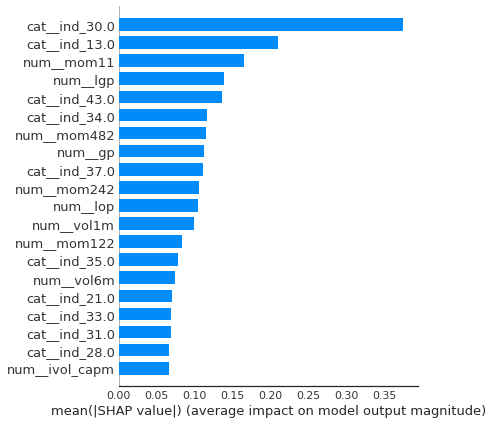

In [56]:
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)

shap.summary_plot(shap_values_XGBoost_test, X_test, 
                  plot_type="bar", plot_size=(6,6), max_display=20)

In [7]:
# Evaluate performance of XGB models:
r2_xgb1 = r2_score(y_test, xgb1.predict(X_test))
r2_xgbgs = r2_score(y_test, xgbgs.predict(X_test))
r2_xgbo = r2_score(y_test, optuna_xgb.predict(X_test))

print('Min_prd: ', min_prd)
print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
      r2_score(y_test, np.ones(len(y_test))*y_test.mean()))
print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_xgb1)
print('XGB GS test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_xgbgs)
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_xgbo)


Min_prd:  650
Constant guess:  6.466409312983865 0.0
XGB test: 6.390771035406137 0.020476758928961947
XGB GS test: 6.344917696653318 0.045586733442827376
Optuna XGB test: 6.336654870859579 0.048473194170501666


In [8]:
col_ignore = ['RET', 'prd']
col_cat = ['ind']
col_num = [x for x in train.columns if x not in col_ignore+col_cat]
for col in col_num:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())
for col in col_cat:
    train[col] = train[col].fillna(value=-1000)
    test[col] = test[col].fillna(value=-1000)
​
X_train = train.copy()
y_train = X_train.pop('RET')
X_test = test.copy()
y_test = X_test.pop('RET')
y_train.reset_index(inplace=True, drop=True)
​
feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                        ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                        remainder="passthrough")
​
print('Number of features before transformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ')
print('Number of features after transformation: ', X_train.shape)

X_train0 = X_train.copy()
y_train0 = y_train.copy()

X_train.drop(columns=['remainder__prd'], inplace=True)
X_test.drop(columns=['remainder__prd'], inplace=True)
​
print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
​
xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=300, max_depth=5, eta=0.03, colsample_bytree=0.6)
xgb1.fit(X_train, y_train)
print('XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
​
time1 = time.time()
xgb = XGBRegressor(tree_method = 'gpu_hist')
param_grid = {'n_estimators':[400, 700], 'max_depth':[2,3,4], 'eta':[0.006, 0.012, 0.02], 'subsample':[0.6], 'colsample_bytree':[0.6]}
xgbm = GridSearchCV(xgb, param_grid, cv=2, verbose=2, scoring='r2')
xgbm.fit(X_train, y_train)
print('XGB', xgbm.best_params_, xgbm.best_score_, time.time()-time1)
print('XGB train:', mean_absolute_error(y_train, xgbm.predict(X_train)), r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

SyntaxError: invalid character in identifier (2143843005.py, line 10)

In [ ]:
time1 = time.time()
def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):
​
    params = {
    "tree_method": 'gpu_hist',
    "verbosity": 0,  # 0 (silent) - 3 (debug)
    "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
    "max_depth": trial.suggest_int("max_depth", 2, 5),
    "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.05),
    "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
    "subsample": trial.suggest_uniform("subsample", 0.3, 0.95),
    "alpha": trial.suggest_loguniform("alpha", 0.1, 30.0),
    "lambda": trial.suggest_loguniform("lambda", 0.1, 200.0),
    "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
    "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }
​
    temp_out = []
​
    for i in range(cv_runs):
​
        X = X_train
        y = y_train
        model = XGBRegressor(**params, njobs=-1)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] = model.predict(X_B)
            y_pred_train[train_index] = model.predict(X_A)
​
        score_train = r2_score(y_train, y_pred_train)
        score_test = r2_score(y_train, y_pred) 
        overfit = (score_train-score_test)
        temp_out.append(score_test-cv_regularizer*overfit)
​
    return (np.mean(temp_out))
​
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=optuna_trials)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")
optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_xgb = XGBRegressor(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)
print('Optuna XGB train:', 
      mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), time.time()-time1)
​
# Evaluate performance of XGB models:
r2_xgb1 = r2_score(y_test, xgb1.predict(X_test))
r2_xgbgs = r2_score(y_test, xgbm.predict(X_test))
r2_xgbo = r2_score(y_test, optuna_xgb.predict(X_test))
​
print('Min_prd: ', min_prd)
print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
      r2_score(y_test, np.ones(len(y_test))*y_test.mean()))
print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_xgb1)
print('XGB GS test:', mean_absolute_error(y_test, xgbm.predict(X_test)), r2_xgbgs)
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_xgbo)
​
results.loc[results.min_prd==min_prd,'xgbf':'xgbo'] = r2_xgb1, r2_xgbgs, r2_xgbo

In [ ]:
# for loop to see appx performance over the whole sample with some rolling window

time0 = time.time()

#min_prd_list = range(100, 676, 25)
min_prd_list = [125]
windows_width = 40*12
cv_regularizer=0.05
optuna_trials = 2

min_prd = 100
    
with open('../input/kaggle-46pkl/IMLEAP_v4.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+2))]
df_cnt = df.count()
empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
df.drop(columns=empty_cols, inplace=True)
display(df.shape, df.head(), df.year.describe(), df.count())

df = df[(df.RET>-50)&(df.RET<75)]
meanret = df.groupby('prd').RET.mean().to_frame().reset_index().rename(columns={'RET':'mRET'})
df = pd.merge(df, meanret, on='prd', how='left')
df.RET = df.RET-df.mRET
df.drop(columns='mRET', inplace=True)

features_miss_dummies = ['amhd', 'BAspr']
for col in features_miss_dummies:
    if col in df.columns:
        df[col+'_miss'] = df[col].isnull().astype(int)

df.reset_index(inplace=True, drop=True)
temp_cols = ['PERMNO', 'year']
train = df[df.prd<(min_prd+windows_width)]
test = df[df.prd==(min_prd+windows_width)]
train.drop(columns=temp_cols, inplace=True)
test.drop(columns=temp_cols, inplace=True)

col_ignore = ['RET', 'prd']
col_cat = ['ind']
col_num = [x for x in train.columns if x not in col_ignore+col_cat]
for col in col_num:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())
for col in col_cat:
    train[col] = train[col].fillna(value=-1000)
    test[col] = test[col].fillna(value=-1000)

X_train = train.copy()
y_train = X_train.pop('RET')
X_test = test.copy()
y_test = X_test.pop('RET')
y_train.reset_index(inplace=True, drop=True)

feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                        ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                        remainder="passthrough")

print('Number of features before transformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ')
print('Number of features after transformation: ', X_train.shape)

X_train0 = X_train.copy()
y_train0 = y_train.copy()

X_train.drop(columns=['remainder__prd'], inplace=True)
X_test.drop(columns=['remainder__prd'], inplace=True)

print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=300, max_depth=5, eta=0.03, colsample_bytree=0.6)
xgb1.fit(X_train, y_train)
print('XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))

time1 = time.time()
xgb = XGBRegressor(tree_method = 'gpu_hist')
param_grid = {'n_estimators':[400, 700], 'max_depth':[2,3,4], 'eta':[0.006, 0.012, 0.02], 'subsample':[0.6], 'colsample_bytree':[0.6]}
xgbm = GridSearchCV(xgb, param_grid, cv=2, verbose=2, scoring='r2')
xgbm.fit(X_train, y_train)
print('XGB', xgbm.best_params_, xgbm.best_score_, time.time()-time1)
print('XGB train:', mean_absolute_error(y_train, xgbm.predict(X_train)), r2_score(y_train, xgbm.predict(X_train)), time.time()-time1)

time1 = time.time()
def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

    params = {
    "tree_method": 'gpu_hist',
    "verbosity": 0,  # 0 (silent) - 3 (debug)
    "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
    "max_depth": trial.suggest_int("max_depth", 2, 5),
    "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.03),
    "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
    "subsample": trial.suggest_uniform("subsample", 0.3, 0.95),
    "alpha": trial.suggest_loguniform("alpha", 0.1, 30.0),
    "lambda": trial.suggest_loguniform("lambda", 0.1, 200.0),
    "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
    "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train
        model = XGBRegressor(**params, njobs=-1)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] = model.predict(X_B)
            y_pred_train[train_index] = model.predict(X_A)

        score_train = r2_score(y_train, y_pred_train)
        score_test = r2_score(y_train, y_pred) 
        overfit = (score_train-score_test)
        temp_out.append(score_test-cv_regularizer*overfit)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=optuna_trials)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")
optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_xgb = XGBRegressor(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)
print('Optuna XGB train:', 
      mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), time.time()-time1)

# Evaluate performance of XGB models:
r2_xgb1 = r2_score(y_test, xgb1.predict(X_test))
r2_xgbgs = r2_score(y_test, xgbm.predict(X_test))
r2_xgbo = r2_score(y_test, optuna_xgb.predict(X_test))

print('Min_prd: ', min_prd)
print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
      r2_score(y_test, np.ones(len(y_test))*y_test.mean()))
print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_xgb1)
print('XGB GS test:', mean_absolute_error(y_test, xgbm.predict(X_test)), r2_xgbgs)
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_xgbo)

results.loc[results.min_prd==min_prd,'xgbf':'xgbo'] = r2_xgb1, r2_xgbgs, r2_xgbo
    
print(time.time()-time0, results)

In [16]:
df.skew()

PERMNO          0.087933
prd            -0.198148
mom482          1.193992
mom242          0.890617
year           -0.198149
RET             0.792396
ind            -0.131010
bm             -0.590142
op             -0.827249
gp              0.446368
inv             1.261316
mom11           0.275975
mom122          0.651943
amhd           -0.376405
ivol_capm       1.226450
ivol_ff5        1.236885
beta_bw         0.457922
MAX             1.345936
vol1m           1.211599
vol6m           1.144974
vol12m          1.088969
size            0.379107
lbm            -0.595647
lop            -0.846113
lgp             0.433002
linv            1.218153
llme            0.419597
l1amhd         -0.378887
l1MAX           1.346688
l3amhd         -0.383315
l3MAX           1.348446
l6amhd         -0.388782
l6MAX           1.347230
l12amhd        -0.399100
l12MAX          1.346688
l12mom122       0.660565
l12ivol_capm    1.225928
l12ivol_ff5     1.237615
l12beta_bw      0.494384
l12vol6m        1.136219


In [15]:
df

,PERMNO,prd,mom482,mom242,year,RET,ind,bm,op,gp,inv,mom11,mom122,amhd,ivol_capm,ivol_ff5,beta_bw,MAX,vol1m,vol6m,vol12m,BAspr,size,lbm,lop,lgp,linv,llme,l1amhd,l1MAX,l1BAspr,l3amhd,l3MAX,l3BAspr,l6amhd,l6MAX,l6BAspr,l12amhd,l12MAX,l12BAspr,l12mom122,l12ivol_capm,l12ivol_ff5,l12beta_bw,l12vol6m,l12vol12m,amhd_miss,BAspr_miss
0,10025,649,30.604529,47.614289,2012,6.600503,15.0,-0.953163,0.060639,0.373348,-0.025756,0.1724,14.759414,1.259688,1.204700,0.923609,1.058419,2.5839,1.533648,2.224711,2.413616,0.404975,5.260005,-1.100725,0.176879,0.498498,-0.078728,5.226473,1.278464,2.9882,0.371854,1.383731,4.1328,0.513906,1.510489,8.7149,0.558214,1.431610,2.9882,0.397878,7.446355,1.532176,1.429862,1.297452,2.318278,2.736604,0,0
1,10025,650,97.106725,44.386493,2012,22.413854,15.0,-0.953163,0.060639,0.373348,-0.025756,-0.9851,13.571797,1.141539,0.765013,0.647098,1.026432,1.4066,0.866870,1.761031,2.337123,0.579206,5.250206,-1.100725,0.176879,0.498498,-0.078728,5.238599,1.259688,2.5839,0.404975,1.369098,3.7563,0.490055,1.482684,9.2927,0.468883,1.488235,2.5839,0.579216,20.525370,1.116961,0.998634,1.245832,2.151214,2.495713,0,0
2,10025,651,138.786753,50.502876,2012,9.260382,15.0,-0.899741,0.072943,0.362002,0.184931,26.1222,18.270241,1.103795,1.517394,1.511676,1.007201,5.7938,1.525676,1.485825,2.334760,0.136519,5.482288,-0.953163,0.060639,0.373348,-0.025756,5.188325,1.141539,1.4066,0.579206,1.278464,2.9882,0.371854,1.460316,8.6057,0.567577,1.494722,1.4066,0.307377,28.446093,1.852721,1.680914,1.262682,2.178625,2.343239,0,0
3,10025,652,162.913720,87.364374,2012,4.114279,15.0,-0.899741,0.072943,0.362002,0.184931,7.8760,60.787559,1.047262,0.937883,0.768468,0.991882,3.1364,0.989203,1.371582,2.299344,0.578902,5.558824,-0.953163,0.060639,0.373348,-0.025756,5.001724,1.103795,5.7938,0.136519,1.259688,2.5839,0.404975,1.383731,4.1328,0.513906,1.504704,5.7938,0.367918,0.922674,1.208446,0.908065,1.307383,2.056547,2.325010,0,0
4,10025,653,174.780357,113.102274,2012,16.416518,15.0,-0.899741,0.072943,0.362002,0.184931,7.1633,72.766685,0.949094,1.120278,0.963537,1.038772,4.3231,1.269428,1.271617,2.116573,0.335306,5.628101,-0.953163,0.060639,0.373348,-0.025756,5.005778,1.047262,3.1364,0.578902,1.141539,1.4066,0.579206,1.369098,3.7563,0.490055,1.523562,3.1364,0.681302,14.425587,2.072178,1.968630,1.081815,2.335976,2.367897,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48154,93423,672,NaN,85.363516,2014,2.891556,7.0,-1.226522,0.100139,0.189565,0.154149,-1.5931,18.300911,-3.226472,0.779887,0.759569,0.902643,1.4066,0.908718,1.377351,1.451315,0.029163,8.244170,-0.835300,0.096950,0.203164,-0.031126,8.179936,-3.222051,4.6275,0.029163,-3.315129,1.8033,0.081566,-3.386130,2.4529,0.029481,-3.092530,4.6275,0.029163,50.350497,0.765013,0.647098,0.792883,1.553267,1.526357,0,0
48155,93423,673,NaN,95.330763,2014,1.794075,7.0,-1.226522,0.100139,0.189565,0.154149,-0.0249,15.793176,-3.219131,0.952419,0.914672,0.949362,2.1480,1.275081,1.248010,1.359812,0.029163,8.247775,-0.835300,0.096950,0.203164,-0.031126,8.155703,-3.226472,1.4066,0.029163,-3.255144,3.6344,0.029163,-3.355495,6.5831,0.029163,-3.181713,1.4066,0.029163,59.229231,2.117291,1.899401,0.771122,1.459107,1.609127,0,0
48156,93423,674,NaN,73.564394,2014,1.531531,7.0,-1.226522,0.100139,0.189565,0.154149,1.9681,11.776170,-3.241532,0.914882,0.855551,0.932978,2.3892,0.997929,1.240860,1.341014,0.029163,8.255716,-0.835300,0.096950,0.203164,-0.031126,8.178869,-3.219131,2.1480,0.029163,-3.222051,4.6275,0.029163,-3.388181,2.9005,0.029163,-3.257544,2.1480,0.029163,65.920814,0.979222,0.920754,0.772685,1.454548,1.602632,0,0
48157,93423,675,NaN,65.099184,2014,-5.751390,7.0,-1.909081,0.130961,0.232296,-0.146767,5.1656,20.864465,-3.238086,0.837567,0.751698,0.990565,2.4722,0.881300,1.221605,1.319646,0.047048,8.306082,-1.226522,0.100139,0.189565,0.154149,8.120186,-3.241532,2.3892,0.029163,-3.22

In [ ]:
results

In [ ]:
print('Total time for a script: ', time.time()-time0)

In [ ]:
results.iloc[:,1:].mean()

In [ ]:
# 3yr window, trials=20, cv_reg=0.03: 0.88%. runs 1 hr.
# 3yr, t=40, cv_reg=0.04: 0.96%.



In [12]:
display(X_train, X_val, X_test)

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__BAspr,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l1BAspr,num__l3amhd,num__l3MAX,num__l3BAspr,num__l6amhd,num__l6MAX,num__l6BAspr,num__l12amhd,num__l12MAX,num__l12BAspr,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,num__BAspr_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
0,2.440252,0.030032,-1.497142,1.080837,0.724789,0.010338,-0.001164,-0.769063,0.061164,-0.521796,-0.613313,0.588274,-0.300375,-0.346009,-0.753732,-0.858156,-0.246214,-0.287970,-2.285884,0.420012,0.545504,-1.453573,-0.079910,0.006677,-0.437054,-0.263244,-0.017419,-0.263946,-0.307586,-0.080405,0.615517,-0.196028,-0.055520,-0.437054,-0.300325,1.723461,-0.612851,-0.587156,-0.248782,-0.897198,-0.999512,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.943299,-0.222745,-1.497142,1.080837,0.724789,0.010338,-0.101503,-0.679058,0.111973,-0.476189,-0.779485,0.796765,0.336568,0.151111,-0.611420,-0.768969,-0.067952,-0.289231,-2.285884,0.420012,0.545504,-1.453573,-0.103939,0.066074,-0.314577,-0.248255,-0.011362,-1.055385,-0.403408,-0.066179,-0.733851,-0.412131,-0.085070,-0.314577,-0.258891,0.909845,-0.555438,-0.378270,-0.329453,-0.907155,-0.987610,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.107274,-0.246470,-1.497142,1.080837,0.724789,0.010338,-0.589553,-0.665144,0.154523,-0.408752,-0.524974,0.808655,-0.458075,-0.365669,-0.517451,-0.719170,-0.391055,-0.327156,-2.285884,0.420012,0.545504,-1.453573,-0.115354,0.117049,0.323205,-0.070163,0.018450,-0.444897,-0.264606,-0.061915,-0.784494,-0.392271,-0.064350,0.323205,-0.377451,0.554145,-0.862790,-0.815012,-0.193126,-0.992504,-0.974490,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.685620,-0.374008,-1.497142,1.080837,0.724789,0.010338,-0.618918,-0.822612,0.211327,-0.498429,-0.506168,0.804064,-0.440318,-0.506501,-0.577175,-0.709441,0.015571,-0.361888,-2.285884,0.420012,0.545504,-1.453573,-0.092495,0.159737,-0.472485,-0.392958,0.078257,-0.321323,-0.249523,0.002885,-0.268268,-0.303054,-0.075501,-0.472485,-0.344694,0.702872,-0.546726,-0.572587,0.058540,-0.900193,-0.950343,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.690976,-0.960773,-1.116726,0.846425,0.659979,-0.425881,-1.749070,-0.921894,0.244523,0.492161,0.500216,0.802548,-0.766582,0.249959,-0.365264,-0.586161,-0.355706,-0.554908,-1.350873,1.033453,0.734261,-0.196466,-0.107086,0.216727,-0.454704,0.013279,0.129583,0.322169,-0.070310,0.009010,-1.065697,-0.400682,-0.079914,-0.454704,-0.286153,0.816731

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__BAspr,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l1BAspr,num__l3amhd,num__l3MAX,num__l3BAspr,num__l6amhd,num__l6MAX,num__l6BAspr,num__l12amhd,num__l12MAX,num__l12BAspr,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,num__BAspr_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
36,-0.447636,1.503621,-0.616017,0.807145,0.566597,-0.676510,0.041370,-0.444748,0.286301,-0.897920,-0.885205,0.669968,-0.996079,-0.899538,-0.823745,-0.714925,-0.357029,-0.373732,-0.394250,-0.569229,-0.440817,0.242727,-0.275573,0.267270,-0.269506,-0.318411,0.205912,-0.104132,-0.331265,0.072720,-0.946680,-0.412905,0.484859,-0.269506,-0.423203,2.672025,-0.595621,-0.602738,0.655205,-0.705329,-0.016263,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,1.082342,2.932444,0.409891,-0.407999,0.054079,-0.291606,-0.494304,2.201976,1.496388,-0.425977,-0.353926,-0.845733,-0.672869,-0.675338,-0.443324,-0.122958,0.004582,-1.042218,0.421057,0.116165,0.326541,-1.125382,-1.573113,1.527156,-0.594924,0.712950,1.761770,-0.679498,0.038660,1.822095,0.159410,0.331043,2.221642,-0.594924,0.995690,1.607994,-0.186524,-0.124067,-2.448014,0.095269,0.861902,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,-0.038815,1.490517,-0.764228,1.661493,1.180223,-0.148263,0.073340,0.476343,0.792124,-1.047382,-0.969301,-1.318185,-1.001774,-1.186375,-1.471881,-1.437878,-0.154287,-0.845688,-0.283119,1.622306,1.928796,-1.026000,-1.010973,0.805248,-0.393897,-0.194811,0.822153,-1.143382,-0.218875,0.889428,-0.854871,-0.437584,1.100826,-0.393897,-0.315926,1.487194,-1.219011,-1.187009,-0.936426,-1.256309,-0.357296,-0.178017,-0.078007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,0.725718,2.932444,1.004495,-1.707367,-0.945570,-0.468686,1.596658,2.201976,1.897724,1.685851,0.595604,-0.920109,2.095057,1.318192,2.145037,2.084527,-0.322355,-1.567221,1.564946,-2.080395,-1.770265,-0.728135,-2.319771,1.908623,0.307918,0.395609,2.123751,2.460112,0.569178,2.168014,2.476404,4.909389,-0.140420,0.307918,4.010015,2.157728,1.577745,1.776789,3.967493,2.218228,2.230892,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,1.156386,1.442577,-1.101432,1.080693,0.088267,-0.321219,0.139841,0.631494,-2.086450,-1.158357,-1.062442,-0.191328,-0.798725,-0.987976,-1.260964,-1.413439,-0.466201,2.825176,-0.664197,0.890849,-0.008299,0.969864,2.717759,-2.082807,-1.103496,-0.468662,-2.064685,-1.156894,-0.468742,-2.049128,-1.029393,-0.463778,-1.998789,-1.103496,-0.456639,1.337993,-1.117885,-1.

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__BAspr,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l1BAspr,num__l3amhd,num__l3MAX,num__l3BAspr,num__l6amhd,num__l6MAX,num__l6BAspr,num__l12amhd,num__l12MAX,num__l12BAspr,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,num__BAspr_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_46.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
37,-0.370711,1.045747,-0.616017,0.807145,0.566597,-0.676510,0.375087,0.151844,0.324364,-0.926429,-0.835087,0.819344,-0.767050,-0.415347,-0.837416,-0.742606,-0.273727,-0.347390,-0.394250,-0.569229,-0.440817,0.242727,-0.416237,0.291945,-1.011197,-0.358964,0.243817,-0.839387,-0.324342,0.095959,-0.731315,-0.357240,0.260356,-1.011197,-0.440167,2.672025,-0.081076,-0.058999,0.166738,-0.602469,-0.391493,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,1.562862,2.932444,0.409891,-0.407999,0.054079,-0.291606,1.619434,1.765912,1.497371,-0.321803,-0.310475,-0.819265,-0.310528,-0.604683,-0.665054,-0.198205,0.019889,-0.948273,0.421057,0.116165,0.326541,-1.125382,-1.415715,1.505979,-0.687561,0.002301,1.688294,-0.429360,0.854002,1.819425,0.480177,0.086252,2.144114,-0.687561,2.133388,2.306243,1.035512,1.048353,-2.348474,0.271762,0.884246,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,-0.017971,1.548951,-0.764228,1.661493,1.180223,-0.148263,0.001117,0.335290,0.784002,-1.173535,-1.074915,-1.418253,-1.138869,-1.358698,-1.498212,-1.529875,-0.196580,-0.841639,-0.283119,1.622306,1.928796,-1.026000,-0.975310,0.799418,-1.016899,-0.156416,0.818801,-0.878843,-0.312308,0.904621,-1.013453,-0.255808,1.068031,-1.016899,-0.067369,1.237983,-0.498111,-0.379121,-1.343626,-1.164610,-0.710352,-0.178017,-0.078007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184,0.995702,2.932444,1.004495,-1.707367,-0.945570,-0.468686,-0.118384,2.201976,1.897724,1.946351,2.146835,-0.986489,1.522755,1.681061,2.134220,2.084527,2.409377,-1.570553,1.564946,-2.080395,-1.770265,-0.728135,-2.259244,1.908623,2.084007,-0.324324,1.933517,1.854294,0.172582,2.168014,2.476404,4.909389,-0.140420,2.084007,3.674272,0.206004,2.463395,2.423646,-0.487464,2.218228,2.230892,-0.178017,-0.078007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
224,1.147943,1.282408,-1.101432,1.080693,0.088267,-0.321219,0.057190,0.589992,-2.076221,-1.190013,-1.156021,-0.079273,-0.976936,-0.943820,-1.358742,-1.372436,-0.454743,2.832604,-0.664197,0.890849,-0.008299,0.969864,2.738320,-2.088544,-0.813583,-0.468032,-2.077690,-0.794177,-0.457275,-2.050656,0.040278,-0.467010,-2.036770,-0.813583,-0.457157,1.051903,-1.203442,-1.138

In [ ]:
results0

In [10]:
# create validation set 
val_indx = X_train0.remainder__prd == min_prd+windows_width-1
X_val = X_train0[val_indx]
X_val.drop(columns='remainder__prd', inplace=True)
y_val = y_train0[val_indx]
display(X_val, y_val)
train_indx = X_train0.remainder__prd < min_prd+windows_width-1
X_train = X_train0[train_indx]
X_train.drop(columns='remainder__prd', inplace=True)
y_train = y_train0[train_indx]
display(X_train, y_train)

NameError: name 'X_train0' is not defined

In [13]:
neurons_base = 16
dropout_rate = 0.05
# n_b=8 was ok with small overfit.
# n_b=32 starts clearly overfitting. 
# 128 fits clearly slower than 64 and becomes somewhat unstable. regularization could make it work, but i see no reason to go wider.
# 64 seems to have nice balance of flexibility and runtime, but its variance may be too large. dropout makes variance vene worse.
# 6 hidden layers is probably most this architecture can hold

# in this framework the optimal model seems to have width of 16 or 32, somehow regularized. try l1/l2?
# w32 can take at most 0.03 dropout.
# w16 looks good w/o dropout.

# more general point:
# main drawback of dropout is in incresing variance
# for textbook problems with high s/n ratio (e.g., mnist) this may be ok.
# for application like this with very low s/n ratio dropout may be a bad idea.

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*32, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

222721


In [8]:
neurons_base = 16
dropout_rate = 0.05

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*27, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*9, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*3, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

# similar problem as before: model seems ok in terms of flexibility and variance, but adding dropout breaks it before i can fix overfitting.
# the solution is to either use smaller models or to use laternative regularizers (which do not increase variance.)

2022-09-06 01:56:18.346069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 01:56:18.351748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 01:56:18.352749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 01:56:18.354627: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

110289


ysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 01:56:22.790430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-06 01:56:22.791027: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14879 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


2022-09-06 01:56:23.446034: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
34/34 - 2s - loss: 203.5653 - mean_squared_error: 203.5653 - val_loss: 134.1529 - val_mean_squared_error: 134.1529
Epoch 2/1000
34/34 - 0s - loss: 202.2396 - mean_squared_error: 202.2396 - val_loss: 133.9866 - val_mean_squared_error: 133.9866
Epoch 3/1000
34/34 - 0s - loss: 201.9889 - mean_squared_error: 201.9889 - val_loss: 133.8872 - val_mean_squared_error: 133.8872
Epoch 4/1000
34/34 - 0s - loss: 201.7041 - mean_squared_error: 201.7041 - val_loss: 133.9403 - val_mean_squared_error: 133.9403
Epoch 5/1000
34/34 - 0s - loss: 201.2448 - mean_squared_error: 201.2448 - val_loss: 133.7487 - val_mean_squared_error: 133.7487
Epoch 6/1000
34/34 - 0s - loss: 200.6950 - mean_squared_error: 200.6950 - val_loss: 134.1508 - val_mean_squared_error: 134.1508
Epoch 7/1000
34/34 - 0s - loss: 200.2834 - mean_squared_error: 200.2834 - val_loss: 134.3009 - val_mean_squared_error: 134.3009
Epoch 8/1000
34/34 - 0s - loss: 200.2230 - mean_squared_error: 200.2230 - val_loss: 134.6417 - val_mean_

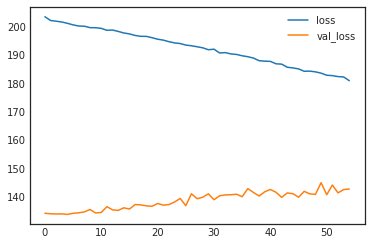

In [9]:
early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
time1 = time.time()
optimizer_adam = tf.keras.optimizers.Adam()
model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_snn.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_snn.predict(X_train)), 
       r2_score(y_val, model_snn.predict(X_val)),
       r2_score(y_test, model_snn.predict(X_test))])
print(time.time()-time1)

In [11]:
X_train.skew()

num__mom482       2.014820
num__mom242       1.343044
num__bm           0.122894
num__op          -0.848916
num__gp           0.607772
                   ...    
cat__ind_45.0    19.090080
cat__ind_46.0    79.436081
cat__ind_47.0    12.898892
cat__ind_48.0    20.318332
cat__ind_49.0    13.162803
Length: 92, dtype: float64

In [ ]:
X_val

In [ ]:
# on nns:
# - try classic regularizers
# - try differene architecture (not snnn)
